<a href="https://colab.research.google.com/github/damithkawshan/Radar-and-Navigation/blob/main/Radar_Assignment_2_160026P.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EN4353 - Radar and Navigation - Assignment 02
###160026P - A. G. D. K. Anhettigama

Link to Colab Notebook : https://colab.research.google.com/drive/1EKUOVoafKmLgVk-NP17xQgqxtLKgYxNY?usp=sharing




#Initialization

##Import required libraries and .csv files


In [154]:
#Load required libraries
import pandas as pd
import cmath
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
cycol = cycle('bgrcmk')

from google.colab import drive
drive.mount('/content/drive')

#Load Dataset and define parameters

url_re = 'https://raw.githubusercontent.com/damithkawshan/Radar-and-Navigation/main/real_component.csv'
I_n = pd.read_csv(url_re,sep=';',header=None,squeeze=True)


url_im = 'https://raw.githubusercontent.com/damithkawshan/Radar-and-Navigation/main/imag_component.csv'
Q_n = pd.read_csv(url_im,sep=';',header=None,squeeze=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Define Parameters

###Radar Description

Pulse Repetition Frequency $(PRF) = 1800Hz$\
Horizontal Beam Width $(\theta_H) = 2 ^\circ$\
Number of Revs per minute $(revol\: speed) = 12$\
Radar Frequency $(F_{radar}) = 720MHz $\
Speed of Light $(C_{light}) = 3\times10^8 ms^{-1}$

###Signal Information

Sampling Frequency $(F_{s(orig)}) = 1080 kHz$\
Downsample Factor $(M) = 20$\
No. of Samples $(L)=27000$\
Range Slots $(C) = 30$
No of Pulses Trasmitted $(N) = \frac{L}{C} = \frac{27000}{30} = 900$ 

After Phase Quadrature Detection Following Quadrature Components are passed into Pulse Doppler Processing Stages.
\
$I(t) = A(t)sin(\theta(t))$\
$Q(t) = A(t)cos(\theta(t))$\
where $\theta(t) = 2\pi f_dt - \pi$ and $|A(t)| \approx$ for three consecutive samples.

$10^{th}\:sample$ is taken when downsample the signal.


complex signal in $n^{th}$ range slot $W[n] = I[n]+jQ[n]$

Impulse response of MTI canceller $h[n] = \delta[n]-4\delta[n-1]+\delta[n-2]$

\
#####Parameters Required for detect object categories

Object  | Velocity $(ms^{-1})$ | Threshold | Encode 
--------|----------------------|-----------|-------
Cloud | 50 | 1.05 | 1
Ground Clutter | 0 |-|2
Rain Clutter | 20 | 0.9 |3
Birds | 35 | 1.05 | 4
Air-Crafts | 150 | 0.5 | 5
No object | - | - | 0


In [155]:
F_s_orig = (1080*1000) #sampling freq
M = 20 #downsampling factor
F_s = F_s_orig/M
Radar_Fr = 720*10e6 #radar frequency 720MHz
PRF = 1800 #PRF
theta_H = 2 #degrees
revol_speed = 12 #rpm
C_light = 3*10e8 #speed of light

#Signal Parameters
df_W = I_n+1j*Q_n
W_n = df_W.to_numpy()
C = 30

L = len(W_n)
N = int(len(W_n)/C)

#Object speed array
#each item is in the format [speed,threhsold,encode] 
dict_obj = {'Cloud Clutter':[50,1.05,1],'Ground Clutter':[0,None,2],'Rain Clutter':[20,0.9,3],'Birds':[35,1.05,4],'Air-Crafts':[150,0.5,5],'No object':[None,None,0]}




#Question 01
First we will consider $I(t)$:
$$
\begin{aligned}
I(t) &= A(t)cos(2\pi f_dt-\pi)\\
\\
AD\: Conversion \:at \: t=\hat nT_s,\: where \: T_s = \frac{1}{F_{S(orig)}}:  \\
I_0[\hat n] &= A(\hat nT_s)cos(2\pi f_d(\hat nT_s)-\pi) \\ 
\\
MTI \:Cancellation : \\
I_1[\hat n] &= I_0[\hat n]*h[\hat n]\\
&=I_0[\hat n]*(\delta[\hat n]-4\delta[\hat n-1]+\delta[\hat n-2])\\
 &=I_0[\hat n]-4I_0[\hat n-1]+I_0[\hat n-2]\\
 &=A[\hat n]cos[k \hat n-\pi]-4A[\hat n-1]cos[k(\hat n-1)-\pi]+A[\hat n]cos[k(\hat n-2)-\pi] :\: k = 2\pi f_dT_s\\
Let |A[n]| \approx |A[n-1]| \approx |A[n-2]| \approx A :\\

&=A\left\{cos[k \hat n-\pi]-cos\left[k \hat n-(\pi+k)\right]+cos[k \hat n-(\pi+2k)-cos[k \hat n-(\pi+k)]-2cos[k \hat n-(\pi+k)]\right\}\\

&=2A\left\{sin\left[k \hat n-\left(\pi+\frac{k}{2}\right)\right]sin\left(\frac{-k}{2}\right)+sin\left[k \hat n-\left(\pi+\frac{3k}{2}\right)\right]sin\left(\frac{k}{2} \right)-cos[k \hat n-(\pi+k)]\right\}\\

&=2A\left\{sin\left(\frac{k}{2}\right)\left(sin\left[k \hat n-\left(\pi+\frac{3k}{2}\right)\right]-sin\left[k \hat n-\left(\pi+\frac{k}{2}\right)\right]\right)-cos\left[k \hat n-(\pi+k)\right]\right\}\\

&=2A\left\{sin\left(\frac{k}{2}\right)\left(2cos\left[k \hat n-\left(\pi+\frac{3k}{2}+\pi+\frac{k}{2}\right)\frac{1}{2}\right]sin\left(\frac{-k}{2}\right)\right)-cos[k \hat n-\left(\pi+k\right)]\right\}\\

&=-2A\left\{(sin^2\left(\frac{k}{2}\right)+1\right\}cos[k \hat n-(\pi+k)]\\

&=2A\left\{(sin^2\left(\frac{k}{2}\right)+1\right\}cos[k \hat n-k]\\

downsample \:by\: 20: \\

\therefore I[n]&=2A[T_s(2n+10)]\left\{sin^2\left(\frac{2\pi f_d T_s}{2}\right)+1\right\}cos[2\pi f_d T_s (2n+10-1)]\\
I[n]&=2A[T_s(2n+10)]\left\{sin^2\left(\pi f_d T_s\right)+1\right\}cos[2\pi f_d T_s (2n+9)]\\

Similarly\: we\: can\: obtain\: Q[n]\: from\: Q(t)\: as:\\

Q[n]&=2A[T_s(2n+10)]\left\{sin^2\left(\pi f_d T_s\right)+1\right\}sin[2\pi f_d T_s (2n+9)]\\

W[n]&=I[n]+jQ[n]\\
\therefore W[n]&= 2A[T_s(2n+10)]\left(sin^2\left(\pi f_d T_s\right)+1\right)\left( cos[2\pi f_d T_s (2n+9)] + jsin[2\pi f_d T_s (2n+9)] \right)
\end{aligned}
$$

#Question 02

Range bin of the data matrix can be represented as $W[n] = I[n]+jQ[n]$

$\therefore$ Let's plot: \
* $|W[n]|= \sqrt{I[n]^2+Q[n]^2}$
* $ phase\: of\: W[n]$
* $I[n]$
*$Q[n]$

Since most of the times ground clutter can be found closer bins with higher magnitude responses.
By observing those plots we can see that ground clutter can be easily filtered by considering $|W[n]|$ where bins with ground clutter have higher $|W[n]|$.

Therefore we can implement Zero Velocity Filter by simply thresholding $if\: W[n] > Ground\:Clutter \: Threshold:\: 0 \: otherwise\: W[n]$

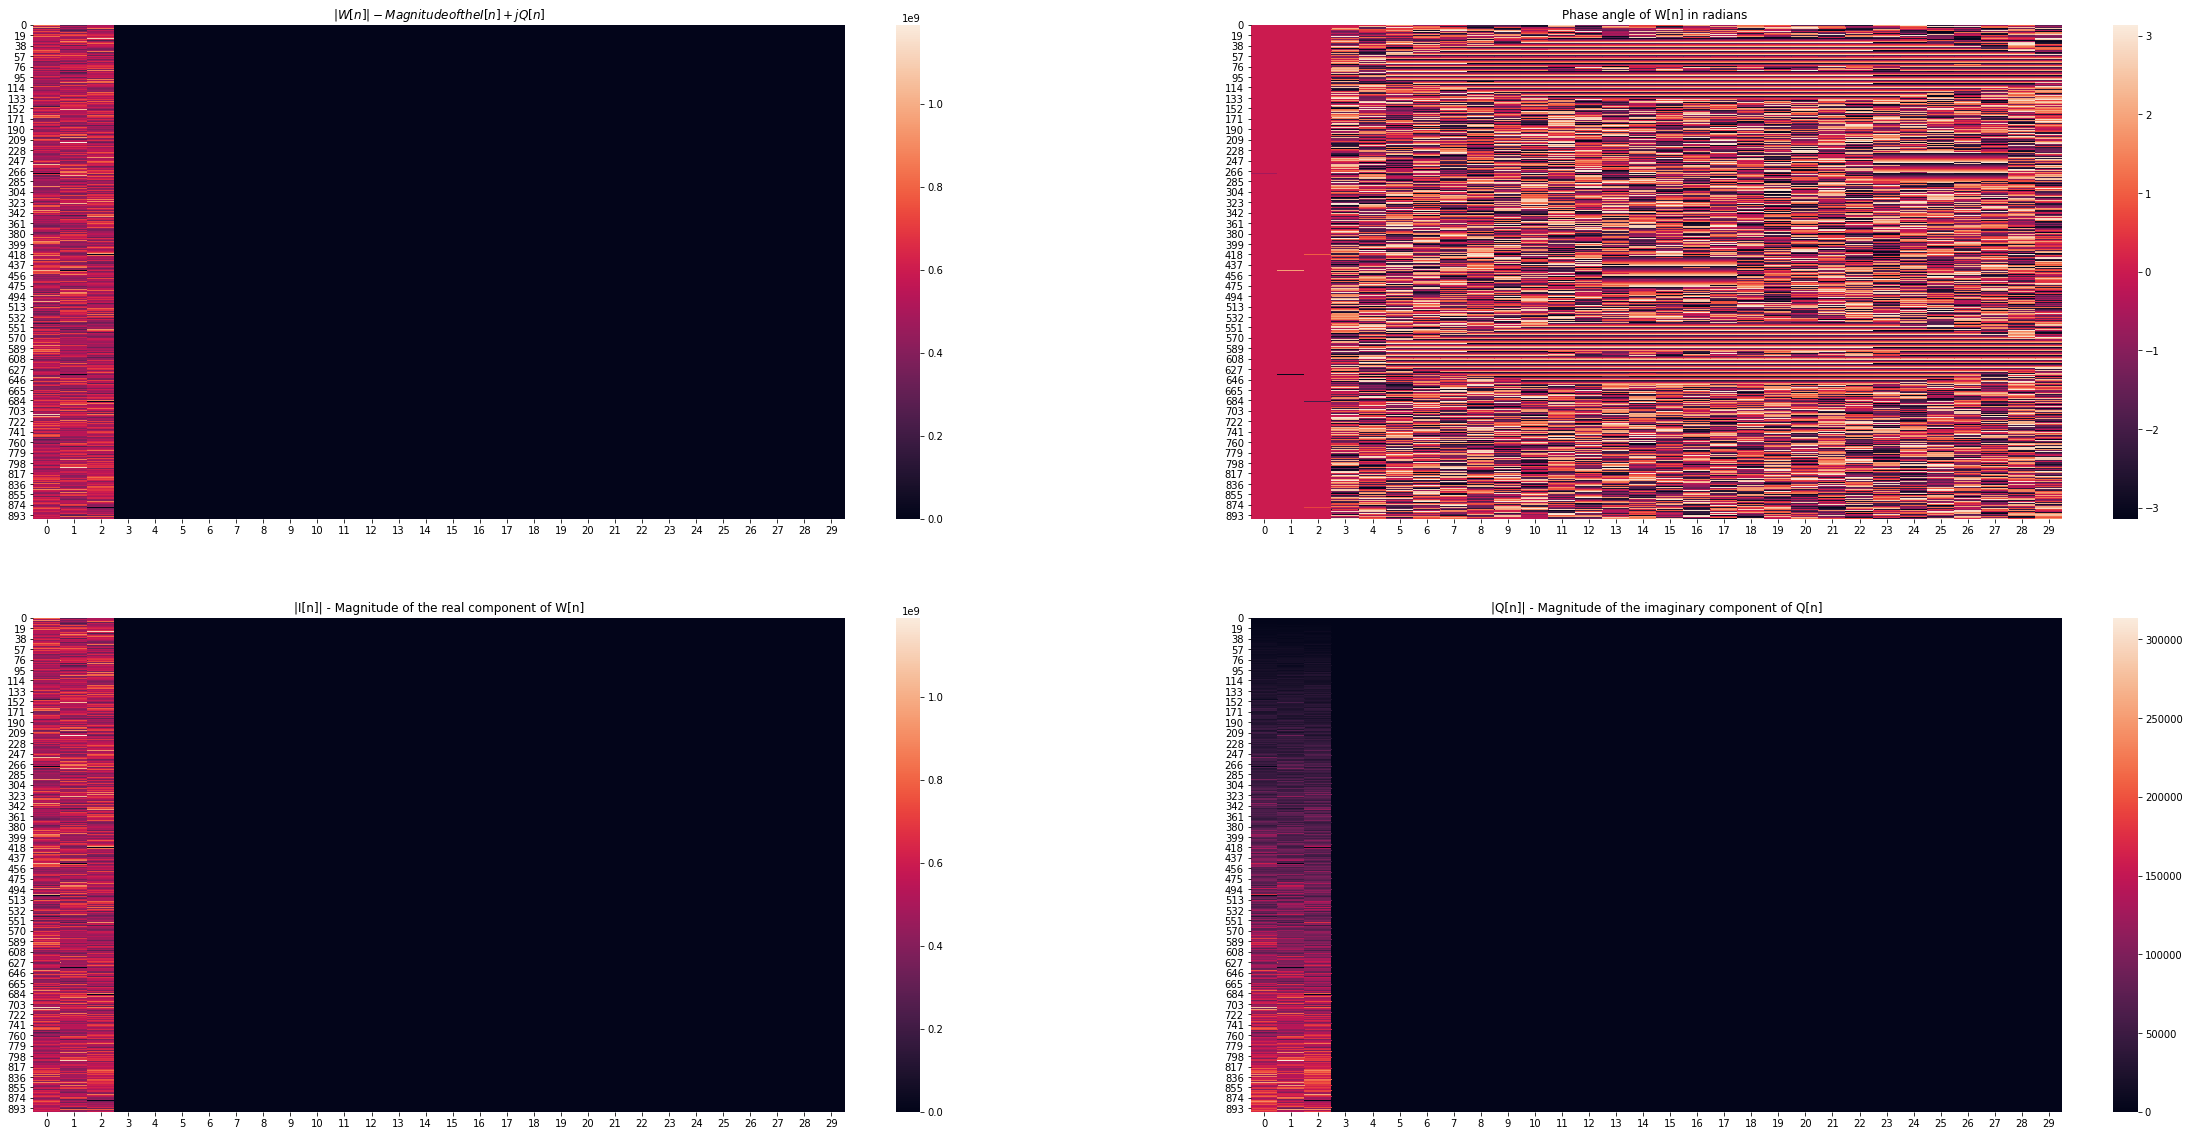

In [156]:
#Question 02

#Generate datamatrix
dataMatrix = W_n.reshape(N,C)

#plot magnitudes of the dataMatrix
phase = np.vectorize(lambda x: cmath.phase(x))
phase_D = phase(dataMatrix)
magn_D = abs(dataMatrix)


f,[[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=(40,20))

ax1.set_title('$|W[n]|- Magnitude of the I[n]+jQ[n]$')
g1 = sns.heatmap(magn_D, square=False,annot=False,cbar=True,ax =ax1)

# plt.title("Phase of the complex number",fontsize = 16)
ax2.set_title('Phase angle of W[n] in radians ')
g2 = sns.heatmap(phase_D, square=False,annot=False,cbar=True,ax =ax2)

#observed that magnitude of ground clutter is higher 

#anaylse quadrature values of the radar data
ax3.set_title('|I[n]| - Magnitude of the real component of W[n]')
real_D = dataMatrix.real
ax4.set_title('|Q[n]| - Magnitude of the imaginary component of Q[n]')
imag_D = dataMatrix.imag

g3 = sns.heatmap(real_D, square=False,annot=False,cbar=True,ax =ax3)
g4 = sns.heatmap(imag_D, square=False,annot=False,cbar=True,ax =ax4)

#Question 03

We plot seperate plots for first 3 bins and other bins.

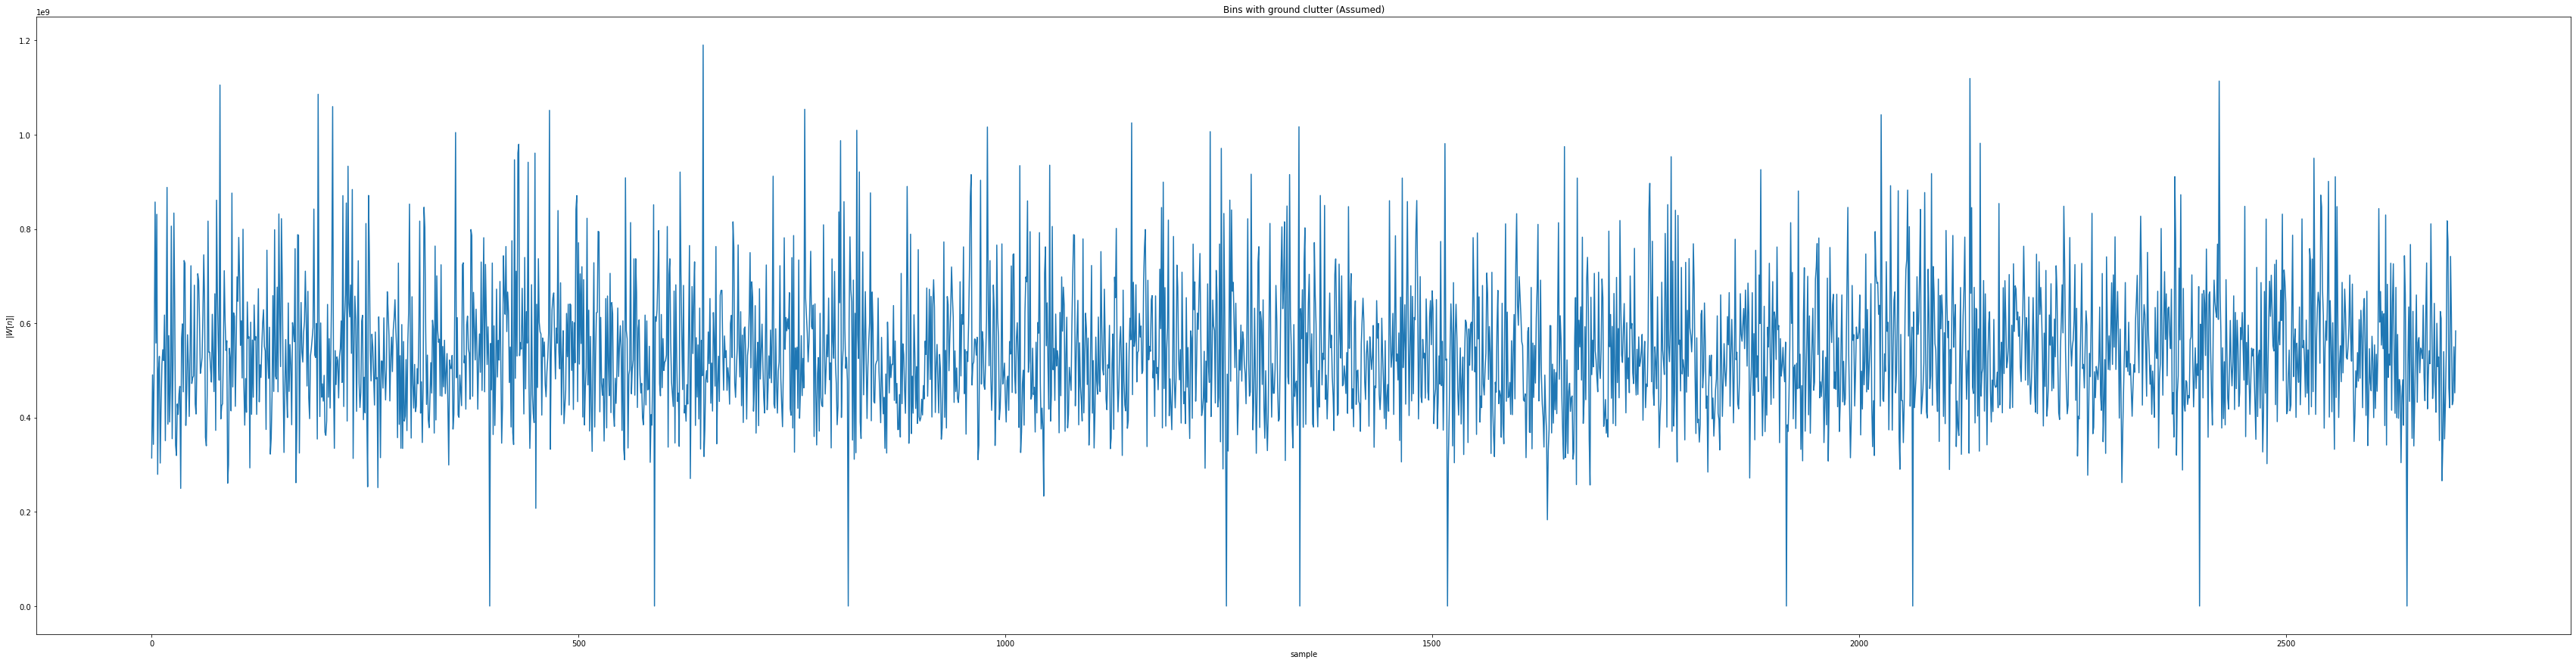

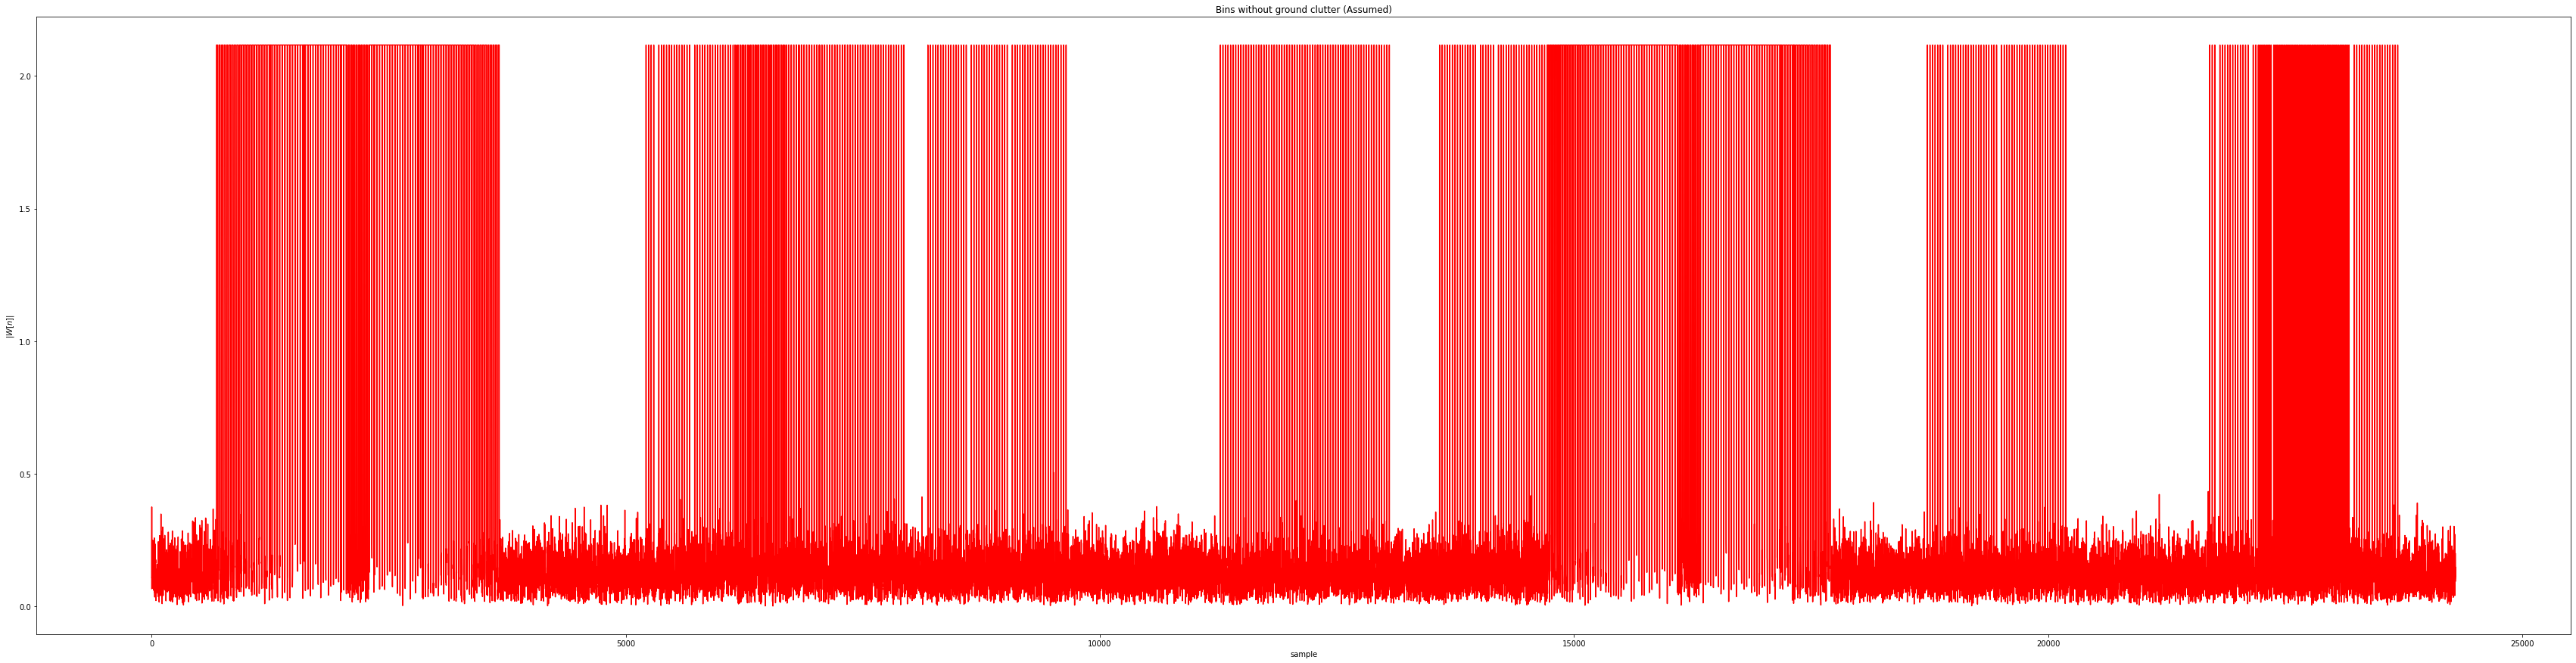

In [157]:
#plot magnitude response of first three bins
G_clutter = magn_D[:,0:3].flatten()
Other = magn_D[:,3:].flatten()

plt.figure(figsize=(60, 15))
ax=plt.plot(G_clutter)
ax=plt.ylabel('$|W[n]|$')
ax=plt.xlabel('sample')
ax=plt.title('Bins with ground clutter (Assumed)')

plt.figure(figsize=(60, 15))
ax=plt.plot(Other,color='r')
ax=plt.ylabel('$|W[n]|$')
ax=plt.xlabel('sample')
ax=plt.title('Bins without ground clutter (Assumed)')
plt.show()

####Zero Velocity Filter Implementation

We can observe that always $|W[n]|$ of bins without ground clutter (GC)(assumed) is upper bounded by 3.

Threrefore we can set the threshold of our proposed zero velocity filter (ZVF) to 3 and remove the GC.

In [158]:
#since ground clutter can be observed at bin 0-2 filter matrix by setting threshold value in phase

threshold = 3

def ZVF(DM,threshold):
  phase_DM = abs(DM)
  filt_DM = np.where(threshold<abs(phase_DM),0,DM)
  return filt_DM

DM_filt = ZVF(dataMatrix, threshold)

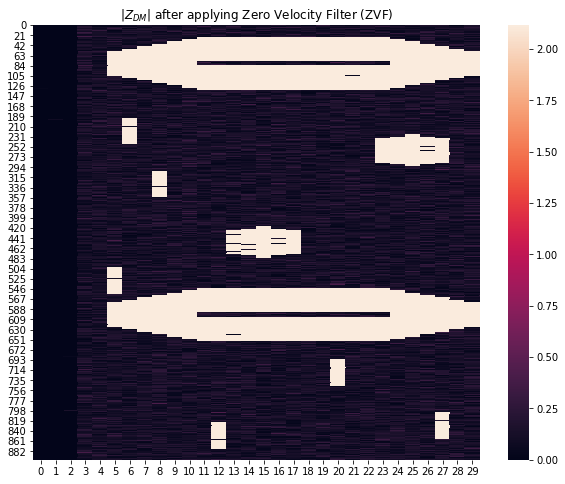

In [159]:
magn_D = abs(DM_filt)
f,ax = plt.subplots(figsize=(10,8))

ax.set_title('$|Z_{DM}| $ after applying Zero Velocity Filter (ZVF)')
ax = sns.heatmap(magn_D, square=False,annot=False,cbar=True)

#Question  04



In [160]:
def plot_fft(fft_matrix,dopl_fr,F_s,single_bin = 0):
  fft_abs = np.abs(fft_matrix)**1
  #reshape the fft output 
  #Fr is the sampling frequency for slow time
  N = len(fft_matrix)

  # Plot the positive frequencies.
  f_pos = np.arange(0, F_s / 2, step=F_s / N)

  # Plot the negative frequencies.
  f_neg = np.arange(-F_s / 2, 0, step=F_s / N)


  
  plt.figure(figsize=(30, 8))
  ax=plt.ylabel('$|W(f)|^2$')
  ax=plt.xlabel('Frequency (Hz)')
  ax=plt.title('FFT representation of W[n]')
  ax = plt.xticks(np.arange(-F_s/2,F_s / 2,(F_s*30)/N))
  if single_bin:
    col0 = next(cycol)
  else:
    col0=None
  plt.plot(f_pos, fft_abs[:(N // 2)],color=col0)
  plt.plot(f_neg, fft_abs[(N // 2):],color=col0)


  for keys,frq in dopl_fr.items():
      col = next(cycol)
      plt.vlines(x=frq,ymin=0,ymax=max(fft_abs.flatten())+50,linestyles='--',colors=col,label=keys)
      plt.vlines(x=-frq,ymin=0,ymax=max(fft_abs.flatten())+50,linestyles='--',colors=col,label=keys)
  
  handles, labels = plt.gca().get_legend_handles_labels() 
  labels, ids = np.unique(labels, return_index=True)
  handles = [handles[i] for i in ids]
  plt.legend(handles, labels, loc='best')
  plt.show()
  return None

{'Cloud Clutter': 240.0, 'Ground Clutter': 0.0, 'Rain Clutter': 96.0, 'Birds': 168.0, 'Air-Crafts': 720.0, 'No object': None}


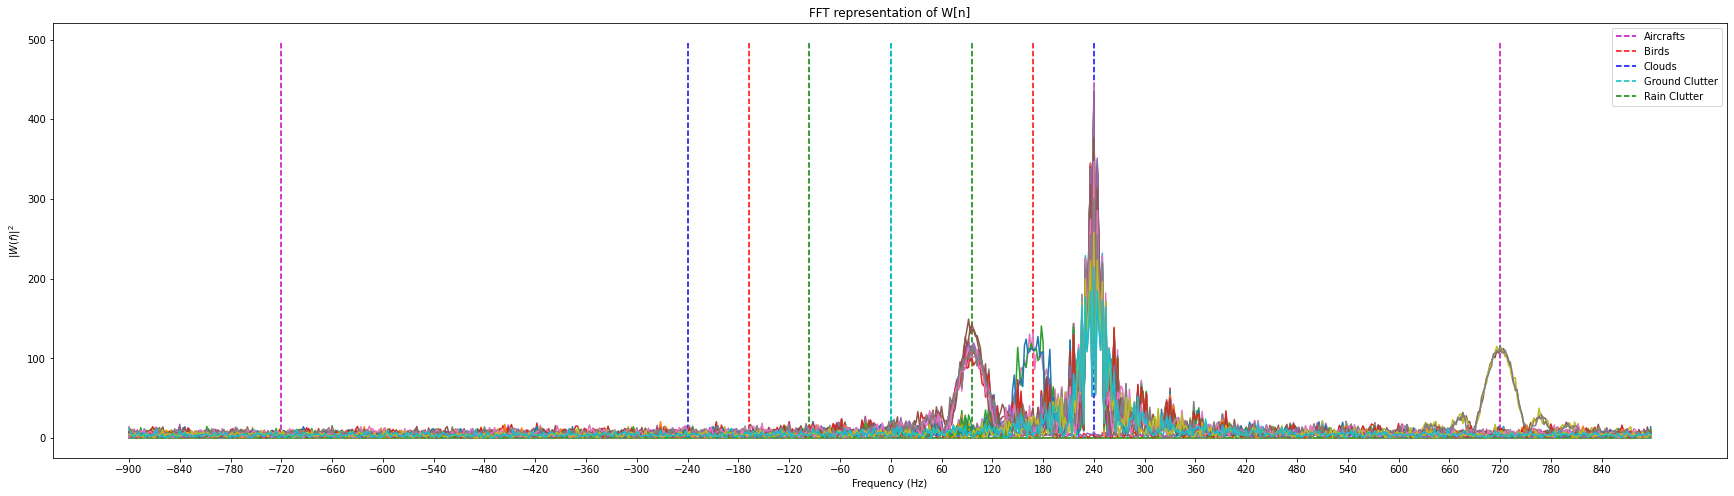

In [161]:
#Get DFT of Datamatrix(ground clutter filtered)
DM_FFT = np.fft.fft(DM_filt[:,:],axis=0)

#calculate dopple frequencies
dict_dopl = {}

for keys,vals in dict_obj.items():
  v_obj = vals[0]
  if v_obj!=None:
    dopl_freq = 2*v_obj/(C_light/Radar_Fr)
    dict_dopl[keys] = dopl_freq
  else:
    dict_dopl[keys] = None

print(dict_dopl)

plot_fft(DM_FFT,dopl_frq,PRF,0)

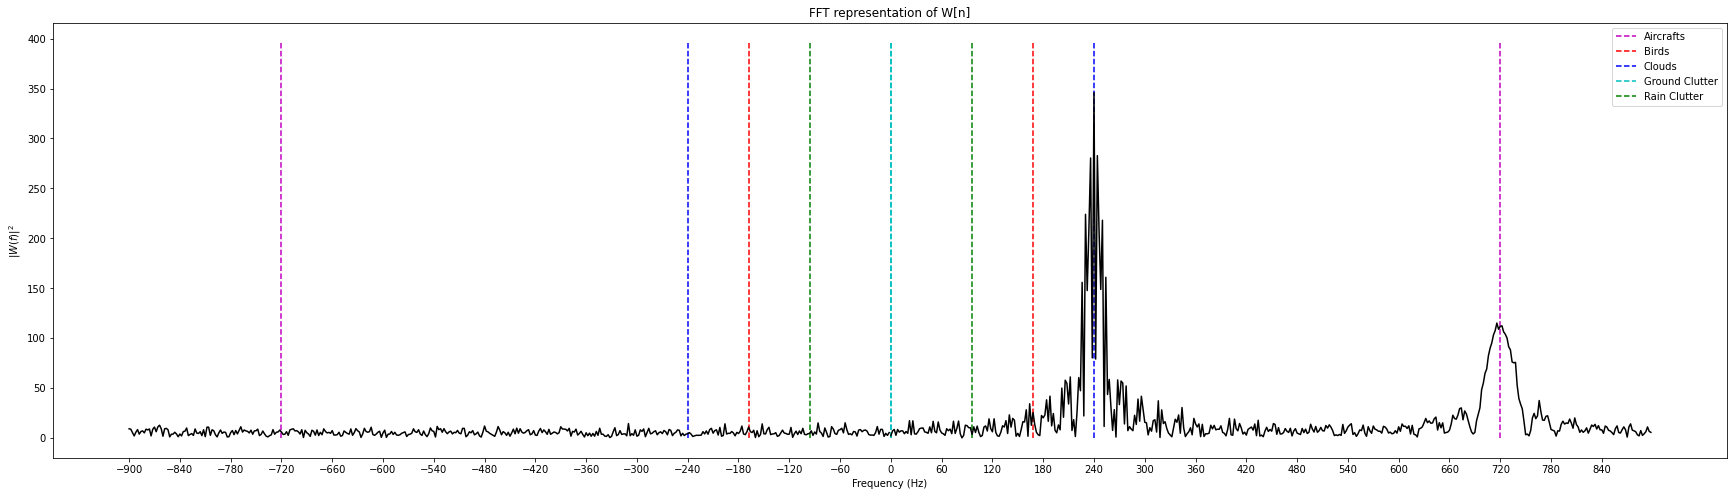

In [162]:
#get FFt for single range bin 
plot_fft(DM_FFT[:,8],dopl_frq,PRF,1)

### Get Bandwidth for Object Detection ---??????

In [163]:
#Bandwidth in Hz
BW = 30

#Question 05

Implement Filter Bank

For simplicity ideal rectangular filters were used as bandpass filters.



In [164]:
#filter implementation

def LPF(cutoff,fs,N,plot):
  f_pos = np.arange(0, fs / 2, step=fs / N)
  H_pos = 1. * (f_pos <= cutoff)
  f_neg = np.arange(-fs / 2, 0, step=fs / N)
  H_neg = 1. * (f_neg >= -cutoff)
  
  H = np.concatenate([H_pos, H_neg])
  H = H.reshape(H.shape[0], 1) 
  if plot:
    plt.plot(H)
  return H

def HPF(cutoff,fs,N,plot):
  f_pos = np.arange(0, fs / 2, step=fs / N)
  H_pos = 1. * (f_pos >= cutoff)
  f_neg = np.arange(-fs / 2, 0, step=fs / N)
  H_neg = 1. * (f_neg <= -cutoff)
  
  H = np.concatenate([H_pos, np.flip(H_neg)])
  H = H.reshape(H.shape[0], 1) 
  if plot:
    plt.plot(H)
  return H

def BPF(cutoff_L,cutoff_R,fs,N,plot):

  L_idx = cutoff_L
  R_idx = cutoff_R

  f_pos = np.arange(0, fs / 2, step=fs / N)
  H_pos = 1. * ((f_pos >= L_idx) & (f_pos <= R_idx))
  f_neg = np.arange(-fs / 2, 0, step=fs / N)
  H_neg = 1. * ((f_pos >= L_idx) & (f_pos <= R_idx))
  
  H = np.concatenate([H_pos, np.flip(H_neg)])
  H = H.reshape(H.shape[0], 1) 
  if plot:
    plt.plot(H)
  return H   


$W[f]$ is passed through doppler filter bank to with different cutoff frequencies.

Let output of the doppler filter $[i] = W_i[f]$

$W_i[f]= W[f]*BPF_{[f_c-BW,f_c+BW]}$

$W_i[n] = ifft(W_i[f])$

After getting inverse DFT threhsolding is performed.

$\therefore $ Final Output Matrix for filter $[i]$ would be:

$if\: W_{final}[n] > threshold[i] = encode[i]\: otherwise \:0 $



In [165]:
#Implement Doppler Filter Bank

dict_final = {}

for keys,vals in dict_dopl.items():
  if (vals !=None and vals!=0):
    print(keys,' cut off frequencies',vals-BW," - ",vals+BW,'Hz')
    filt = BPF(vals-BW,vals+BW,PRF,N,0) #get the filter in freq domain



    FFT_filt = np.multiply(DM_FFT[:,:],filt)#apply filter

    DM_dopl_filt = np.fft.ifft(FFT_filt[:,:],axis=0) # IFFT (DM_FFT)

    threshold = dict_obj[keys][1]
    encode = dict_obj[keys][2]
    DM_final = (abs(DM_dopl_filt)>threshold)*encode #thresholding and encoding

    #write final matrix to dict
    dict_final[keys] = [DM_final,filt,abs(DM_dopl_filt)] 

    #write final matrix to .csv file
    np.savetxt(keys+".csv", matrix, delimiter=",")
  

Cloud Clutter  cut off frequencies 210.0  -  270.0 Hz
Rain Clutter  cut off frequencies 66.0  -  126.0 Hz
Birds  cut off frequencies 138.0  -  198.0 Hz
Air-Crafts  cut off frequencies 690.0  -  750.0 Hz


In [166]:
matrix =dict_final['Air-Crafts'][0]

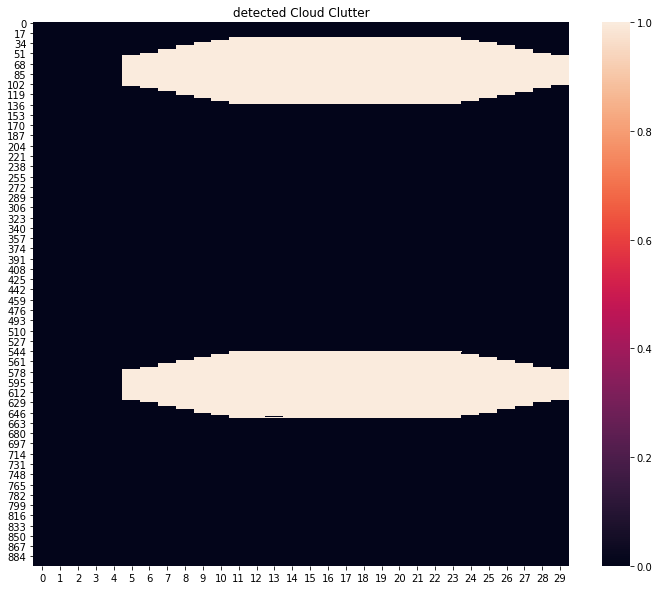

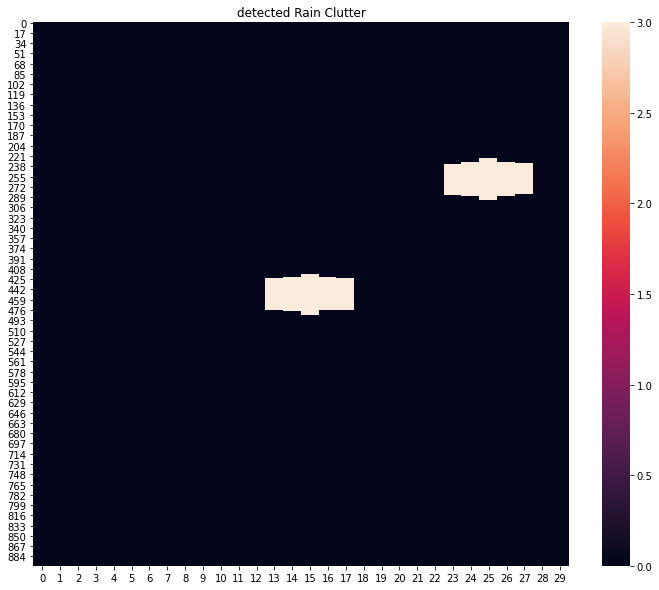

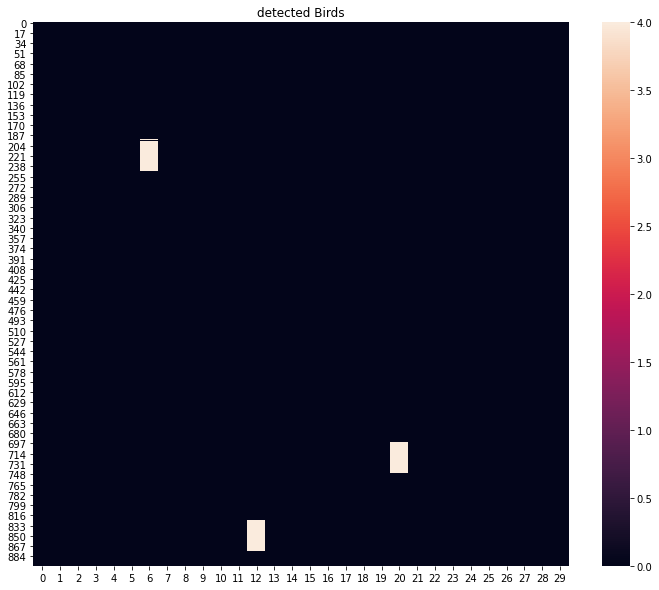

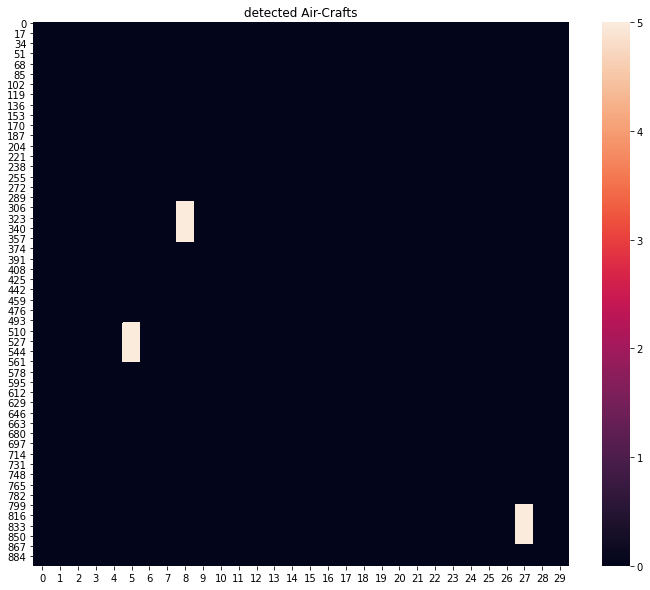

In [167]:
for keys,vals in dict_final.items():
  # f,ax = plt.subplots(figsize=(15,3))
  # ax.set_title('BPF Filter for '+keys)
  # plt.plot(vals[1][:(N // 2)],color='r')
  # plt.plot(vals[1][(N // 2):],color='r')
  f,ax = plt.subplots(figsize=(12,10))
  ax.set_title('detected '+keys)
  ax = sns.heatmap(vals[0], square=False,annot=False,cbar=True)

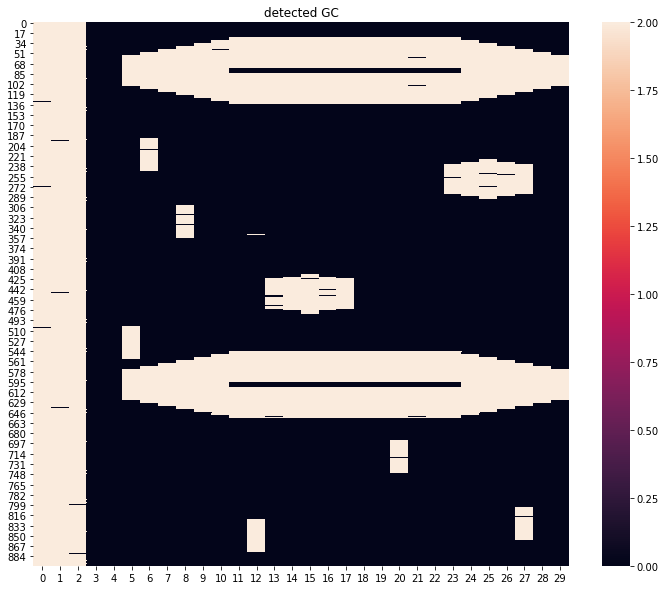

In [168]:
def ZVF(DM,threshold):
  phase_DM = abs(DM)
  filt_DM = np.where(threshold<abs(phase_DM),2,0)
  return filt_DM

DM_filt11 = ZVF(dataMatrix, threshold)

f,ax = plt.subplots(figsize=(12,10))
ax.set_title('detected GC')
ax = sns.heatmap(abs(DM_filt11), square=False,annot=False,cbar=True)

